# **Advanced API functionality**
In this second tutorial we will show some examples of how to executed more sofisticated analysis towards our data.

As we did in the previous tutorial, we need to import both Spark and Oskar APIs, as well as loading our data into a Spark Dataframe variable.

In [1]:
from pyoskar.core import Oskar
from pyoskar.spark.sql import *
from pyoskar.spark.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

## Stats per variant
Here we present the genotypes of the first 10 variants from which the later stats will come out:

In [6]:
df.select(df.id, df.studies.samplesData.alias("genotypes")).show(10, False)

+---------------+-------------------------------------------------------------------------------------------------------------------------+
|id             |genotypes                                                                                                                |
+---------------+-------------------------------------------------------------------------------------------------------------------------+
|22:16054454:C:T|[[[./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [0/1], [./.], [./.], [./.]]]|
|22:16065809:T:C|[[[0/1], [./.], [./.], [./.], [0/1], [./.], [0/1], [./.], [./.], [./.], [./.], [0/1], [0/1], [./.], [./.], [./.], [0/1]]]|
|22:16077310:T:A|[[[./.], [0/1], [0/1], [./.], [./.], [0/1], [./.], [0/1], [./.], [0/1], [./.], [0/1], [./.], [./.], [0/1], [./.], [./.]]]|
|22:16080499:A:G|[[[0/1], [./.], [0/1], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [0/1], [0/1], [./.], [./.], [./.], [./.]]]|
|22:16084621:T:C|[[[

In this case we are applying a transformationthat will lead to adding new data inside the "studies" field, which is empty before we do anything:

In [8]:
df.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "altAlleleCount", "missingAlleleCount", "altAlleleFreq", "maf").show(10, False)

+---------------+-----------+--------------+------------------+-------------+----+
|id             |alleleCount|altAlleleCount|missingAlleleCount|altAlleleFreq|maf |
+---------------+-----------+--------------+------------------+-------------+----+
|22:16054454:C:T|null       |null          |null              |null         |null|
|22:16065809:T:C|null       |null          |null              |null         |null|
|22:16077310:T:A|null       |null          |null              |null         |null|
|22:16080499:A:G|null       |null          |null              |null         |null|
|22:16084621:T:C|null       |null          |null              |null         |null|
|22:16091610:G:T|null       |null          |null              |null         |null|
|22:16096040:G:A|null       |null          |null              |null         |null|
|22:16099957:C:T|null       |null          |null              |null         |null|
|22:16100462:A:G|null       |null          |null              |null         |null|
|22:

Now we proceed to apply a transformation, that means that our dataframe will suffer some kind of change. It is important to know how that transformer works in order to tell spark how to extract the new information:

In [6]:
oskar.stats(df).selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "altAlleleCount", "missingAlleleCount", "altAlleleFreq", "maf").show(10, False)
# oskar.stats(df, missingAsReference=True).selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*") \
#     .select("id", "alleleCount", "altAlleleCount", "missingAlleleCount", "altAlleleFreq", "maf").show(10, False)

+---------------+-----------+--------------+------------------+-------------+---------+
|id             |alleleCount|altAlleleCount|missingAlleleCount|altAlleleFreq|maf      |
+---------------+-----------+--------------+------------------+-------------+---------+
|22:16054454:C:T|2          |1             |32                |0.5          |0.5      |
|22:16065809:T:C|12         |6             |22                |0.5          |0.5      |
|22:16077310:T:A|14         |7             |20                |0.5          |0.5      |
|22:16080499:A:G|8          |4             |26                |0.5          |0.5      |
|22:16084621:T:C|10         |5             |24                |0.5          |0.5      |
|22:16091610:G:T|6          |3             |28                |0.5          |0.5      |
|22:16096040:G:A|18         |9             |16                |0.5          |0.5      |
|22:16099957:C:T|34         |20            |0                 |0.5882353    |0.4117647|
|22:16100462:A:G|32         |16 

## Stats per dataframe
As an example we could also apply a transformation that provides statistics attached to the whole dataframe:

In [8]:
globalStatsTransformationDataframe = oskar.global_stats(df)
globalStatsTransformationDataframe.drop("variantTypeCounts", "variantBiotypeCounts", "consequenceTypesCounts", "chromosomeStats").show()
globalStatsTransformationDataframe.select(explode("variantTypeCounts")).show()
globalStatsTransformationDataframe.select(explode("variantBiotypeCounts")).show(truncate=False)
globalStatsTransformationDataframe.select(explode("consequenceTypesCounts")).show(truncate=False)
globalStatsTransformationDataframe.select(explode("chromosomeStats")).show(truncate=False)
# Ojo pq aun no está acabada la API Java y el numSamples no funciona

+-----------+----------+-------+---------+-----------+-------------+---------------+
|numVariants|numSamples|numPass|tiTvRatio|meanQuality|stdDevQuality|numRareVariants|
+-----------+----------+-------+---------+-----------+-------------+---------------+
|       1000|         0|   4016|1.3342036|    773.252|    765.54596|             []|
+-----------+----------+-------+---------+-----------+-------------+---------------+

+-----+-----+
|  key|value|
+-----+-----+
|  SNV|  894|
|INDEL|  106|
+-----+-----+

+----------------------------------+-----+
|key                               |value|
+----------------------------------+-----+
|IG_C_pseudogene                   |1    |
|IG_V_pseudogene                   |17   |
|protein_coding                    |500  |
|rRNA                              |4    |
|retained_intron                   |192  |
|nonsense_mediated_decay           |166  |
|IG_V_gene                         |18   |
|snRNA                             |6    |
|snoRNA         

## Hardy Weinberg // Mendelian error
Other transformations will not fill existing fields but create new ones, like this new column that appears after we apply HW or Mendelian Error transformations. 

In [14]:
oskar.hardy_weinberg(df,"hgvauser@platinum:illumina_platinum").select("id", "HWE").show(10)
oskar.mendel(df, "NA12877", "NA12878", "NA12879").select("id", "mendelianError").filter(col("mendelianError") != "0").show()

+---------------+--------------------+
|             id|                 HWE|
+---------------+--------------------+
|22:16054454:C:T|                 1.0|
|22:16065809:T:C|                 1.0|
|22:16077310:T:A|  0.9254727474972191|
|22:16080499:A:G|                 1.0|
|22:16084621:T:C|                 1.0|
|22:16091610:G:T|                 1.0|
|22:16096040:G:A|  0.4746014089729329|
|22:16099957:C:T|0.016007636455477054|
|22:16100462:A:G|0.001011008618240...|
|22:16105660:G:A|  0.3037449017426771|
+---------------+--------------------+
only showing top 10 rows

+------------------+--------------+
|                id|mendelianError|
+------------------+--------------+
|22:19748211:CCCC:-|             1|
+------------------+--------------+



## Histogram
This last example shows how easily we can apply transformations at the same time we use some well known python functionality. We would like to know the frequency with which we can find variants depending on the region of our genome, but in this case we will store our transformed dataframe into the standard Pandas Dataframe.

[Text(0, 0.5, 'Counts'), Text(0.5, 0, 'Region')]

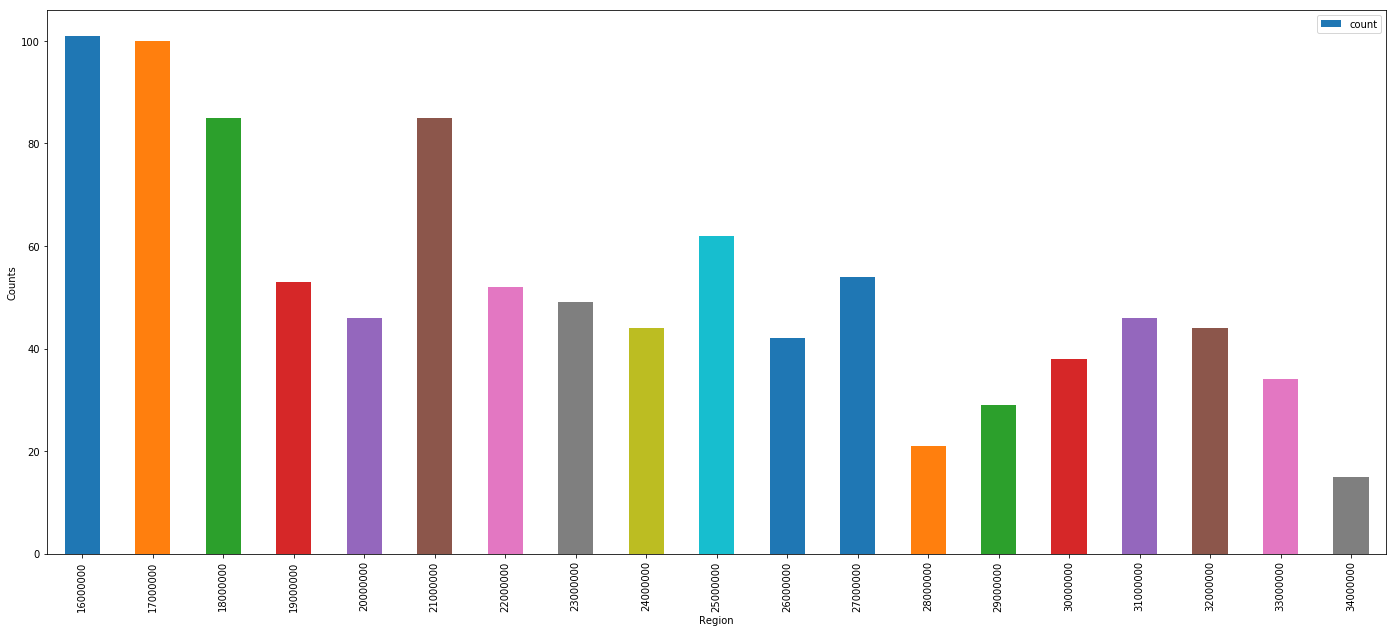

In [5]:
pandaDF = oskar.histogram(df,"start",1000000).toPandas()
histogram = pandaDF.plot(x = "start", y = "count", kind = "bar", figsize=(24,10))
histogram.set(xlabel="Region", ylabel="Counts")

**Note that the region covers from the self x-axis value to the next one*

In [7]:
import pandas as pd
import numpy as np
import scipy as sp
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import get_plotlyjs, init_notebook_mode

get_plotlyjs()
init_notebook_mode(connected=True)
# py.plot([{"x": [1, 2, 3], "y": [3, 1, 6]}])
# table = ff.create_table(pandaDF)

data = [go.Bar(x=pandaDF["start"], y=pandaDF["count"])]
py.plot(data)
# py.plot(data)


'file:///home/roldanx/appl/oskar/oskar-spark/src/main/python/temp-plot.html'